In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image

In [3]:
img_path_1 = '/home/dk/Dataset/indoor_video_8_4k_pngs/img-28.png'
img_path_2 = '/home/dk/Dataset/indoor_video_7_4k_pngs/img-23.png'

img_1 = np.asarray(Image.open(img_path_1))[None, ...]
img_2 = np.asarray(Image.open(img_path_2))[None, ...]
imgs = np.concatenate([img_1, img_2], axis=0)

In [4]:
imgs.shape

(2, 2048, 3584, 3)

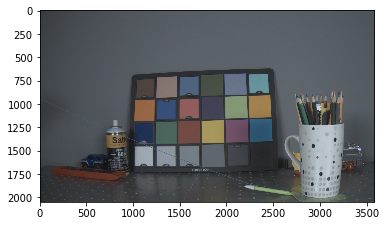

In [5]:
plt.imshow(imgs[0])

In [6]:
def make_grids(rows, cols):
    col, row = np.meshgrid(np.arange(cols), np.arange(rows))
    row = row.reshape(-1)
    col = col.reshape(-1)
    grids = np.stack([row, col], axis=1)
    return grids

In [7]:
def padding(img, kernel_size, stride):
    """
    imgs:a tensor with shape [b, h, w, c]
    kernel_size: [h, w]
    stride:[h, w]
    dilation:
    """
    b, c, h, w = img.size()
    left_padding = 0
    right_padding = 0
    if (w - kernel_size[1] + stride[1]) % stride[1]:
        right_padding = kernel_size[1] - (w - kernel_size[1] + stride[1]) % stride[1]
    
    top_padding = 0
    bottom_padding = 0
    if (h - kernel_size[0] + stride[0]) % stride[0]:
        bottom_padding = kernel_size[0] - (h - kernel_size[0] + stride[0]) % stride[0]
        
    paddings = (left_padding, right_padding, top_padding, bottom_padding)
    img_paded = torch.nn.ZeroPad2d(padding=paddings)(img)
    return img_paded

In [8]:
def extract_img_patches(imgs, kernel_size, stride, dilation):
    """
    imgs:a tensor with shape [b, c, h, w]
    kernel_size: [patch_h, patch_w]
    stride:[patch_h, patch_w]
    dilation:
    """
    assert isinstance(imgs, torch.Tensor)
    assert imgs.dim() == 4
    
    b, c, h, w = imgs.size()
    imgs_paded = padding(imgs, kernel_size, stride)
    imgs_patches = torch.nn.Unfold(kernel_size=kernel_size, stride=stride, dilation=dilation, padding=0)(imgs_paded)
    return imgs_patches

In [9]:
def get_patches_by_id(patch_id, patches, h_splits, w_splits):
    """
    patch_id: id of the patch
    patches: a tensor of shape [b, c*patch_h*patch_w, patch_num]
    """
    _, neibr_ids = near_patch_ids(patch_id, 1, h_splits, w_splits)
    neibr_patches = torch.index_select(patches, dim=2, index=torch.tensor(neibr_ids))
    return neibr_patches

In [10]:
def patch_to_img(patches, patch_id, kernel_size, stride, dilation=1):
    """
    patches: neighbor patches of the patch_grid_id
    patch_grid_id: a scalar of the patch you focus on
    kernel_size: [patch_h, patch_w]
    stride: [patch_h, patch_w]
    
    """
    assert isinstance(patches, torch.Tensor)
    
    neibr_coords, _ = near_patch_ids(patch_id, 1, h_splits, w_splits)
    neibr_coords = np.array(neibr_coords)
    h_scale = len(np.unique(neibr_coords[:, 0]))
    w_scale = len(np.unique(neibr_coords[:, 1]))
    output_size = (patch_h * h_scale, patch_w * w_scale)
    imgs = torch.nn.Fold(output_size=output_size, kernel_size=kernel_size, stride=stride, padding=0)(patches)
    return imgs

In [11]:
img_torch = torch.from_numpy(np.transpose(imgs, [0, 3, 1, 2]))

h_splits = 4
w_splits = 4
B, C, H, W = img_torch.size()
patch_h = H // h_splits
patch_w = W // w_splits
kernel_size = (patch_h, patch_w)
patch_size = (patch_h, patch_w)
stride = (patch_h, patch_w)
dilation = 1

test_patch_id = 12

In [12]:
def near_patch_ids(cur_grid, dis, rows, cols):
    import numbers
    assert isinstance(cur_grid, numbers.Integral)
    
    grids = make_grids(rows, cols)
    coord_to_id = {str(coord): i for i, coord in enumerate(grids)}
    cur_grid_coord = grids[cur_grid]
    x_vals = [_ for _ in range(-dis, dis + 1)]
    y_vals = [_ for _ in range(-dis, dis + 1)]
    coord_detal = np.array([[i, j] for i in x_vals for j in y_vals])
    near_coords = cur_grid_coord + coord_detal
    near_coords[:, 0] = np.clip(near_coords[:, 0], 0, rows-1)
    near_coords[:, 1] = np.clip(near_coords[:, 1], 0, cols-1)
    
    out_ids = []
    out_coords = []
    for coord in near_coords:
        if np.all(coord.tolist() not in out_coords):
            out_coords.append(coord.tolist())
            out_ids.append(coord_to_id[str(coord)])
    return out_coords, out_ids

In [13]:
all_patches = extract_img_patches(img_torch.to(torch.float32), kernel_size, stride, dilation)
all_patches.shape

torch.Size([2, 1376256, 16])

In [14]:
random_grid_patches = get_patches_by_id(test_patch_id, all_patches, h_splits, w_splits)
random_grid_patches.shape

torch.Size([2, 1376256, 4])

In [15]:
random_patch_img = patch_to_img(random_grid_patches, test_patch_id, kernel_size, stride)
random_patch_img.shape

torch.Size([2, 3, 1024, 1792])

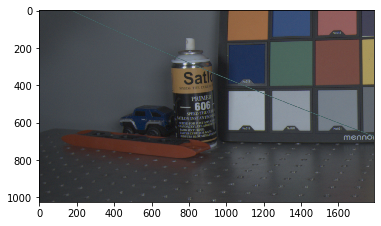

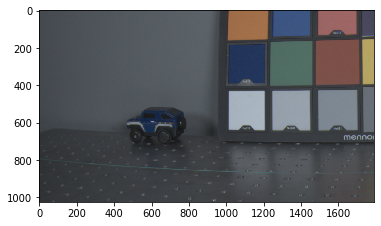

In [16]:
img = random_patch_img[0].permute(1, 2, 0).to(torch.uint8).numpy()
plt.imshow(img)
plt.show()

img = random_patch_img[1].permute(1, 2, 0).to(torch.uint8).numpy()
plt.imshow(img)
plt.show()

## Reference
https://github.com/DAA233/learning-notes/issues/18

### TF

**TF 文档中对函数的介绍如下：**

```python
tf.image.extract_image_patches(
    images,
    ksizes,
    strides,
    rates,
    padding,
    name=None
)
```

+ images: A Tensor. Must be one of the following types: float32, float64, int32, uint8, int16, int8, int64, bfloat16, uint16, half, uint32, uint64.
4-D Tensor with shape [batch, in_rows, in_cols, depth].
+ ksizes: A list of ints that has length >= 4.
The size of the sliding window for each dimension of images.
+ strides: A list of ints that has length >= 4.
1-D of length 4. How far the centers of two consecutive patches are in
the images. Must be: [1, stride_rows, stride_cols, 1].
+ rates: A list of ints that has length >= 4.
1-D of length 4. Must be: [1, rate_rows, rate_cols, 1]. This is the
input stride, specifying how far two consecutive patch samples are in the
input. Equivalent to extracting patches with
patch_sizes_eff = patch_sizes + (patch_sizes - 1) * (rates - 1), followed by
subsampling them spatially by a factor of rates. This is equivalent to
rate in dilated (a.k.a. Atrous) convolutions.
+ padding: A string from: "SAME", "VALID".
The type of padding algorithm to use.
We specify the size-related attributes as:

```python
ksizes = [1, ksize_rows, ksize_cols, 1]
strides = [1, strides_rows, strides_cols, 1]
rates = [1, rates_rows, rates_cols, 1]
```
name: A name for the operation (optional).

上面的函数接口基本上和卷积的操作是一样的，实际上，这种滑动窗口取 patch 的方法就是属于卷积操作的一部分，只不过这里没有 filter，也没有将 patch 和 filter 作卷积的操作。

卷积操作的动态示意图：https://github.com/vdumoulin/conv_arithmetic

返回值是理解这个函数的一个关键。上面函数的返回值是一个维度为 [N, H_L, W_L, k*k*C]，其中 L = H_L * W_L 是总的 patch 数目。

### Pytorch

**在 PyTorch 中，torch.nn.Unfold 可以实现类似的功能。**
```python
torch.nn.Unfold(kernel_size, dilation=1, padding=0, stride=1)

```
Extracts sliding local blocks from a batched input tensor.

+ kernel_size (int or tuple) – the size of the sliding blocks
+ stride (int or tuple, optional) – the stride of the sliding blocks in the input spatial dimensions. Default: 1
+ padding (int or tuple, optional) – implicit zero padding to be added on both sides of input. Default: 0
+ dilation (int or tuple, optional) – a parameter that controls the stride of elements within the neighborhood. Default: 1

它的返回值的维度为 [N, C*k*k, L]，其中 L 为 patch 总数。

### 下面用一个具体的例子来说明：

In [1]:
import tensorflow as tf
tf.enable_eager_execution()
import torch
import numpy as np

# 待提取 patch 的图像，在 TF 和 PyTorch 中有不同的组织方式
# images channel 0
# [[ 0.  1.  2.  3.  4.]
#  [ 5.  6.  7.  8.  9.]
#  [10. 11. 12. 13. 14.]
#  [15. 16. 17. 18. 19.]
#  [20. 21. 22. 23. 24.]]
# images channel 1
# [[25. 26. 27. 28. 29.]
#  [30. 31. 32. 33. 34.]
#  [35. 36. 37. 38. 39.]
#  [40. 41. 42. 43. 44.]
#  [45. 46. 47. 48. 49.]]

# TensorFlow image tensor
tf_images = np.concatenate((np.arange(25).reshape(1, 5, 5, 1).astype(np.float),
                            np.arange(25, 50).reshape(1, 5, 5, 1).astype(np.float)),
                            axis=3)
tf_images = tf.constant(tf_images, dtype=tf.float32)

# PyTorch image tensor
torch_images = np.concatenate((np.arange(25).reshape(1, 1, 5, 5).astype(np.float),
                               np.arange(25, 50).reshape(1, 1, 5, 5).astype(np.float)),
                               axis=1)
torch_images = torch.tensor(torch_images, dtype=torch.float32)

# 指定提取 patch 时的滑动窗口参数
ksizes = 2
strides = 2
rates = 1

# TensorFlow extract patches
tf_patches = tf.extract_image_patches(tf_images,
                                      ksizes=[1, ksizes, ksizes, 1],
                                      strides=[1, strides, strides, 1],
                                      rates=[1, rates, rates, 1],
                                      padding='SAME')  # [N, H_L, W_L, k*k*C]

# PyTorch unfold
def same_padding(images, ksizes, strides, rates):
    assert len(images.size()) == 4
    batch_size, channel, rows, cols = images.size()
    out_rows = (rows + strides[0] - 1) // strides[0]
    out_cols = (cols + strides[1] - 1) // strides[1]
    effective_k_row = (ksizes[0] - 1) * rates[0] + 1
    effective_k_col = (ksizes[1] - 1) * rates[1] + 1
    padding_rows = max(0, (out_rows-1)*strides[0]+effective_k_row-rows)
    padding_cols = max(0, (out_cols-1)*strides[1]+effective_k_col-cols)
    # Pad the input
    padding_top = int(padding_rows / 2.)
    padding_left = int(padding_cols / 2.)
    padding_bottom = padding_rows - padding_top
    padding_right = padding_cols - padding_left
    paddings = (padding_left, padding_right, padding_top, padding_bottom)
    images = torch.nn.ZeroPad2d(paddings)(images)
    return images

# A little different because of the padding
# Maybe we can use a 'SAME' padding like here:
# https://github.com/DAA233/learning-notes/issues/16
torch_images = same_padding(torch_images, (ksizes, ksizes), (strides, strides), (rates, rates))
unfold = torch.nn.Unfold(kernel_size=ksizes,
                         dilation=rates,
                         padding=0,
                         stride=strides)
torch_patches = unfold(torch_images)  # [N, C*k*k, L]


# tf_patches 和  torch_patches 对数据组织的方式不同，但其中的 patch 是一一对应的
# 比如，我们想得到第一个 patch 中第一个通道的值，两种方法可以分别通过：
print(tf.reshape(tf_patches[0, 0, 0, :], (ksizes, ksizes, 2))[:, :, 0])
# tf.Tensor(
# [[0. 1.]
#  [5. 6.]], shape=(2, 2), dtype=float32)
print(torch_patches[0, :, 0].view(2, ksizes, ksizes)[0])
# tensor([[0., 1.],
#         [5., 6.]])

ModuleNotFoundError: No module named 'tensorflow'